<Figure size 640x480 with 0 Axes>

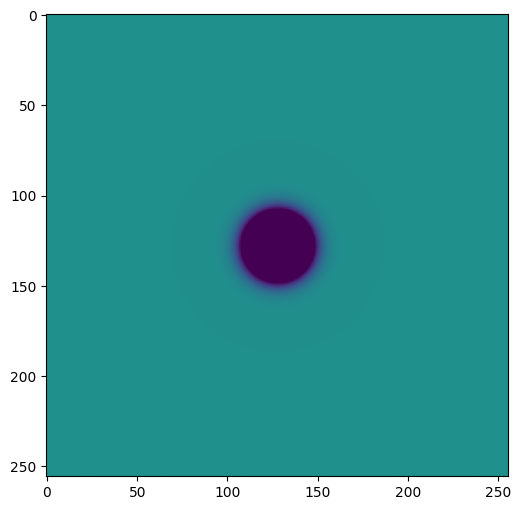

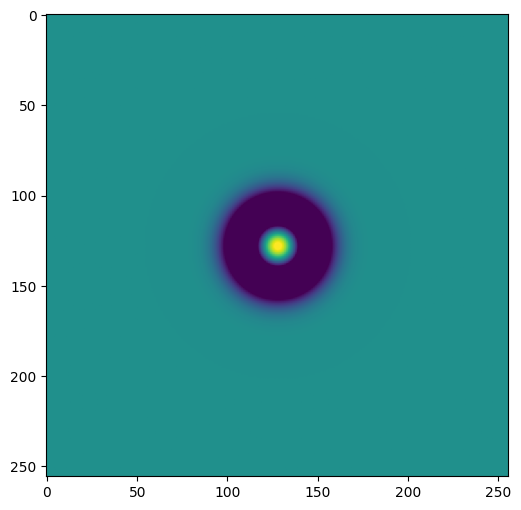

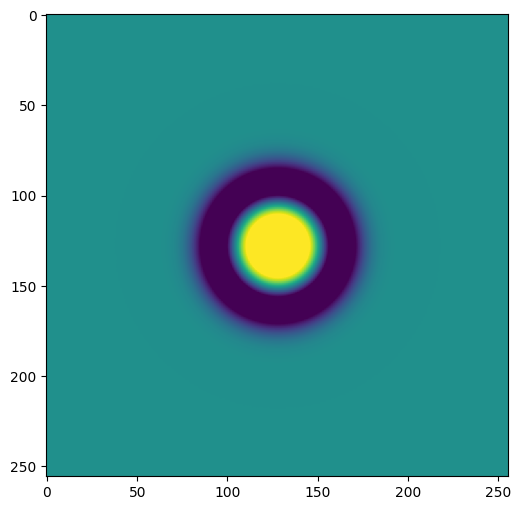

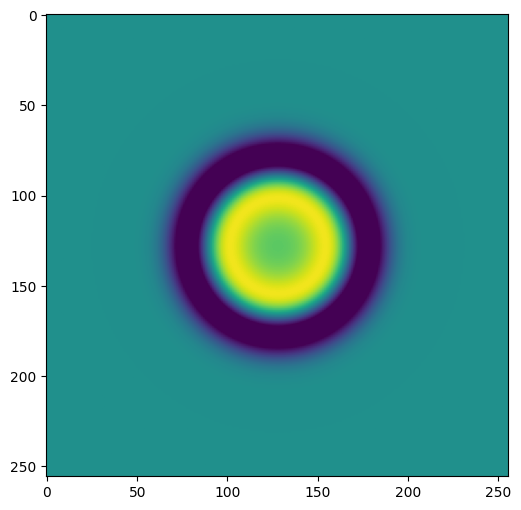

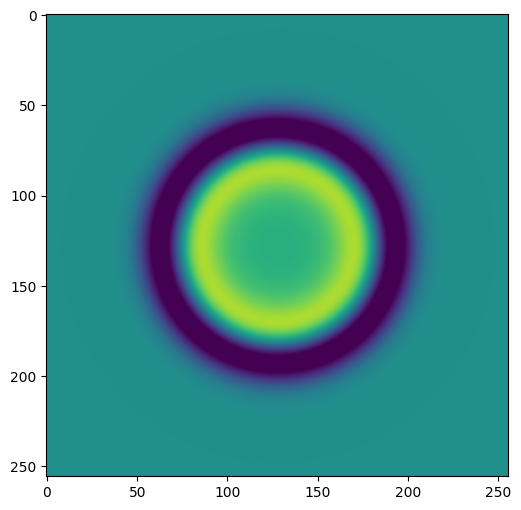

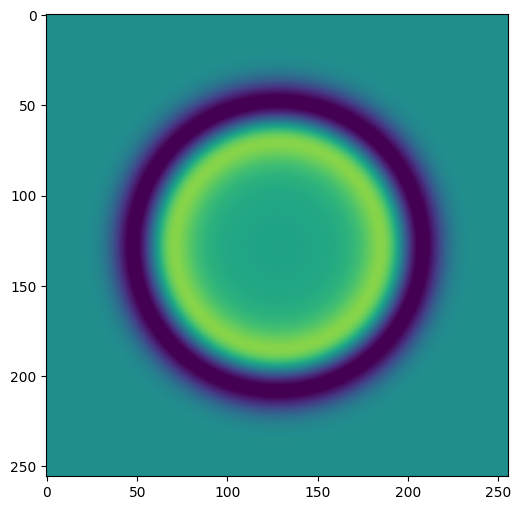

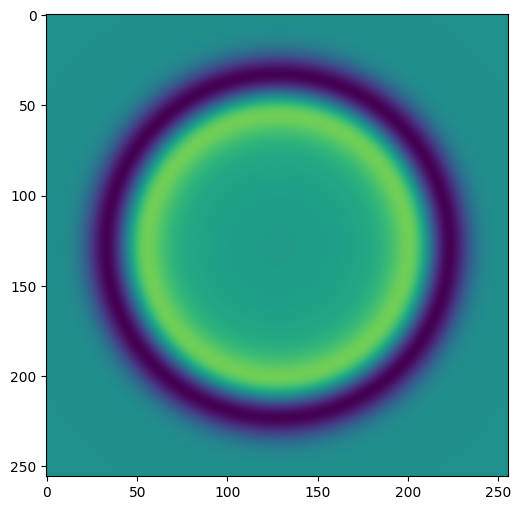

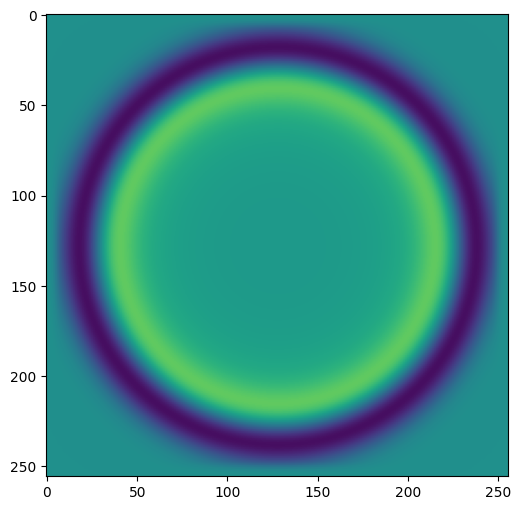

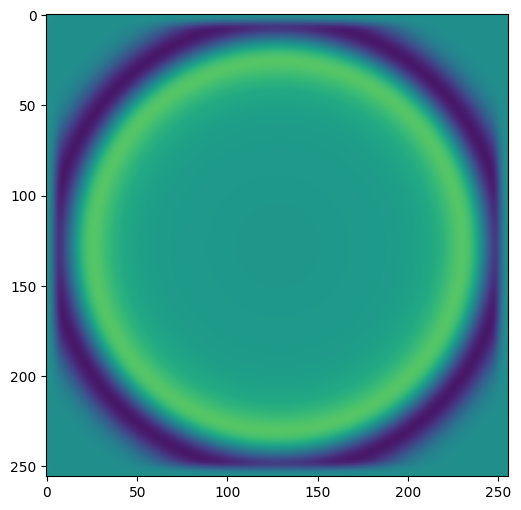

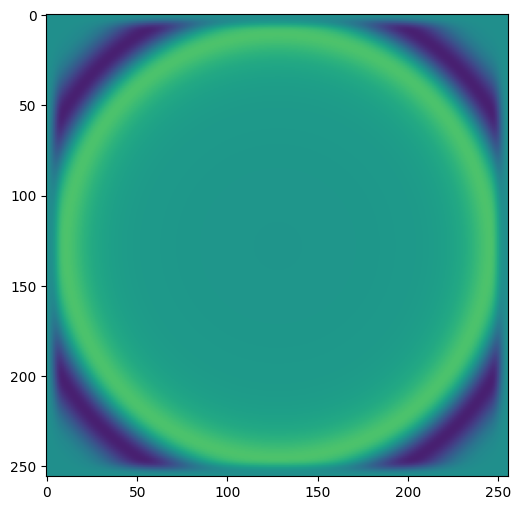

In [1]:
"""
This code is my own python implementation of the SEISMIC_CPML library here: https://github.com/geodynamics/seismic_cpml/blob/master/seismic_CPML_2D_pressure_second_order.f90
"""

import numpy as np
import time

from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_helper import get_dampening_profiles

# TODO: is this faster in parallel with np.roll?

def seismicCPML2D(NX,
                NY,
                NSTEPS,
                DELTAX,
                DELTAY,
                DELTAT,
                NPOINTS_PML,
                velocity,
                density,
                initial_pressures,
                f0=20.,
                dtype=np.float32,
                output_wavefields=True,
                gather_is=None):

    "Run seismicCPML2D"

    ## INPUT PARAMETERS
    velocity = velocity.astype(dtype)
    density = density.astype(dtype)

    if type(gather_is) != type(None): output_gather = True
    else: output_gather = False

    K_MAX_PML = 1.
    ALPHA_MAX_PML = 2.*np.pi*(f0/2.)# from Festa and Vilotte
    NPOWER = 2.# power to compute d0 profile
    Rcoef = 0.001

    STABILITY_THRESHOLD = 1e25
    ##


    # STABILITY CHECKS

    # basically: delta x > np.sqrt(3) * max(v) * delta t
    courant_number = np.max(velocity) * DELTAT * np.sqrt(1/(DELTAX**2) + 1/(DELTAY**2))
    if courant_number > 1.: raise Exception("ERROR: time step is too large, simulation will be unstable %.2f"%(courant_number))
    if NPOWER < 1: raise Exception("ERROR: NPOWER must be greater than 1")


    # GET DAMPENING PROFILES

    [[a_x, a_x_half, b_x, b_x_half, K_x, K_x_half],
     [a_y, a_y_half, b_y, b_y_half, K_y, K_y_half]] = get_dampening_profiles(velocity, NPOINTS_PML, Rcoef, K_MAX_PML, ALPHA_MAX_PML, NPOWER, DELTAT, DELTAS=(DELTAX, DELTAY), dtype=dtype, qc=False)


    # INITIALISE ARRAYS

    kappa = density*(velocity**2)

    pressure_present = initial_pressures[1].astype(dtype)
    pressure_past = initial_pressures[0].astype(dtype)

    memory_dpressure_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressure_dy = np.zeros((NX, NY), dtype=dtype)

    memory_dpressurexx_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressureyy_dy = np.zeros((NX, NY), dtype=dtype)

    if output_wavefields: wavefields = np.zeros((NSTEPS, NX, NY), dtype=dtype)
    if output_gather: gather = np.zeros((gather_is.shape[0], NSTEPS), dtype=dtype)

    # precompute density_half arrays
    density_half_x = np.pad(0.5 * (density[1:NX,:]+density[:NX-1,:]), [[0,1],[0,0]], mode="edge")
    density_half_y = np.pad(0.5 * (density[:,1:NY]+density[:,:NY-1]), [[0,0],[0,1]], mode="edge")


    # RUN SIMULATION

    start = time.time()
    for it in range(NSTEPS):

        # compute the first spatial derivatives divided by density

        value_dpressure_dx = np.pad((pressure_present[1:NX,:]-pressure_present[:NX-1,:]) / DELTAX, [[0,1],[0,0]], mode="constant", constant_values=0.)
        value_dpressure_dy = np.pad((pressure_present[:,1:NY]-pressure_present[:,:NY-1]) / DELTAY, [[0,0],[0,1]], mode="constant", constant_values=0.)

        memory_dpressure_dx = b_x_half * memory_dpressure_dx + a_x_half * value_dpressure_dx
        memory_dpressure_dy = b_y_half * memory_dpressure_dy + a_y_half * value_dpressure_dy

        value_dpressure_dx = value_dpressure_dx / K_x_half + memory_dpressure_dx
        value_dpressure_dy = value_dpressure_dy / K_y_half + memory_dpressure_dy

        pressure_xx = value_dpressure_dx / density_half_x
        pressure_yy = value_dpressure_dy / density_half_y

        # compute the second spatial derivatives

        value_dpressurexx_dx = np.pad((pressure_xx[1:NX,:]-pressure_xx[:NX-1,:]) / DELTAX, [[1,0],[0,0]], mode="constant", constant_values=0.)
        value_dpressureyy_dy = np.pad((pressure_yy[:,1:NY]-pressure_yy[:,:NY-1]) / DELTAY, [[0,0],[1,0]], mode="constant", constant_values=0.)

        memory_dpressurexx_dx = b_x * memory_dpressurexx_dx + a_x * value_dpressurexx_dx
        memory_dpressureyy_dy = b_y * memory_dpressureyy_dy + a_y * value_dpressureyy_dy

        value_dpressurexx_dx = value_dpressurexx_dx / K_x + memory_dpressurexx_dx
        value_dpressureyy_dy = value_dpressureyy_dy / K_y + memory_dpressureyy_dy

        dpressurexx_dx = value_dpressurexx_dx
        dpressureyy_dy = value_dpressureyy_dy

        # apply the time evolution scheme
        # we apply it everywhere, including at some points on the edges of the domain that have not be calculated above,
        # which is of course wrong (or more precisely undefined), but this does not matter because these values
        # will be erased by the Dirichlet conditions set on these edges below
        pressure_future =   - pressure_past \
                            + 2 * pressure_present \
                            + DELTAT*DELTAT*(dpressurexx_dx+dpressureyy_dy)*kappa

        # apply Dirichlet conditions at the bottom of the C-PML layers,
        # which is the right condition to implement in order for C-PML to remain stable at long times

        # Dirichlet conditions
        pressure_future[0,:] = pressure_future[-1,:] = 0.
        pressure_future[:,0] = pressure_future[:,-1] = 0.

        if output_wavefields: wavefields[it,:,:] = np.copy(pressure_present)
        if output_gather:
            gather[:,it] = np.copy(pressure_present[gather_is[:,0], gather_is[:,1]])# nb important to copy


        # check stability of the code, exit if unstable
        if(np.max(np.abs(pressure_present)) > STABILITY_THRESHOLD):
            raise Exception('code became unstable and blew up')

        # move new values to old values (the present becomes the past, the future becomes the present)
        pressure_past = pressure_present
        pressure_present = pressure_future

        #print(pressure_past.dtype, pressure_future.dtype, wavefields.dtype, gather.dtype)
        if it % 10000 == 0 and it!=0:
            rate = (time.time()-start)/10.
            print("[%i/%i] %.2f s per step"%(it, NSTEPS, rate))
            start = time.time()

    output = [None, None]
    if output_wavefields: output[0]=wavefields
    if output_gather: output[1]=gather
    return output


if __name__ == "__main__":


    import matplotlib.pyplot as plt


    # example simulation

    dtype = np.float32

    NX, NY = 256,256
    NSTEPS = 2000
    NPOINTS_PML = 10
    DELTAX, DELTAY = 20,20
    DELTAT = 0.001 # sample rate for FD modelling (s)
    f0 = .5

    velocity = 1500.*np.ones((NX,NY))
    density = 2200.*np.ones((NX,NY))

    xx,yy = np.meshgrid(np.arange(NX), np.arange(NY), indexing="ij")
    p0 = np.exp(-0.5*( ((xx-NX/2)/10)**2 + ((yy-NY/2)/10)**2   ))

    wavefields, _ = seismicCPML2D(
                NX,
                NY,
                NSTEPS,
                DELTAX,
                DELTAY,
                DELTAT,
                NPOINTS_PML,
                velocity,
                density,
                (p0.copy(),p0.copy()),
                f0,
                dtype,
                output_wavefields=True,
                gather_is=None)

    plt.figure()
    s = 5*np.mean(np.abs(wavefields))
    for it in range(0, NSTEPS, NSTEPS//10):
        plt.figure(figsize=(10,6))
        plt.imshow(-wavefields[it,:,:].T, vmin=-s, vmax=s)




In [35]:
def ricker_wavelet(t, f0):
    return (1 - 2*(np.pi*f0*(t - 1/(f0)))**2) * np.exp(-(np.pi*f0*(t - 1/(f0)))**2)

def custom_source_wavelet(x, y, t, sd=1.0):
    """
    Custom source wavelet function based on spatial-temporal variables.
    
    Parameters:
        x: float or array, spatial x-coordinate
        y: float or array, spatial y-coordinate
        t: float or array, time coordinate
        sd: float, standard deviation for the Gaussian envelope

    Returns:
        Source wavelet value as a float or array.
    """
    # Exponential term
    e = -0.5 * (x**2 + y**2 + t**2) / (sd**2)
    # Source wavelet term
    s = 2e3 * (1 + e) * np.exp(e)
    return s 

In [72]:
def seismicCPML2D_with_source(NX,
                              NY,
                              NSTEPS,
                              DELTAX,
                              DELTAY,
                              DELTAT,
                              NPOINTS_PML,
                              velocity,
                              density,
                              initial_pressures,
                              source_position,
                              source_amplitude,
                              source_function,
                              f0=20.,
                              dtype=np.float32,
                              output_wavefields=True,
                              gather_is=None):
    """
    Run seismicCPML2D with external time-varying source passed as an argument
    """

    # INPUT PARAMETERS
    velocity = velocity.astype(dtype)
    density = density.astype(dtype)

    if type(gather_is) != type(None):
        output_gather = True
    else:
        output_gather = False

    K_MAX_PML = 1.
    ALPHA_MAX_PML = 2.*np.pi*(f0/2.)
    NPOWER = 2.
    Rcoef = 0.001

    STABILITY_THRESHOLD = 1e25

    # STABILITY CHECKS
    courant_number = np.max(velocity) * DELTAT * np.sqrt(1/(DELTAX**2) + 1/(DELTAY**2))
    if courant_number > 1.:
        raise Exception("ERROR: time step is too large, simulation will be unstable %.2f"%(courant_number))
    if NPOWER < 1:
        raise Exception("ERROR: NPOWER must be greater than 1")

    # GET DAMPENING PROFILES
    [[a_x, a_x_half, b_x, b_x_half, K_x, K_x_half],
     [a_y, a_y_half, b_y, b_y_half, K_y, K_y_half]] = get_dampening_profiles(velocity, NPOINTS_PML, Rcoef, K_MAX_PML, ALPHA_MAX_PML, NPOWER, DELTAT, DELTAS=(DELTAX, DELTAY), dtype=dtype, qc=False)

    # INITIALISE ARRAYS
    kappa = density*(velocity**2)

    pressure_present = initial_pressures[1].astype(dtype)
    pressure_past = initial_pressures[0].astype(dtype)

    memory_dpressure_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressure_dy = np.zeros((NX, NY), dtype=dtype)

    memory_dpressurexx_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressureyy_dy = np.zeros((NX, NY), dtype=dtype)

    if output_wavefields:
        wavefields = np.zeros((NSTEPS, NX, NY), dtype=dtype)
    if output_gather:
        gather = np.zeros((gather_is.shape[0], NSTEPS), dtype=dtype)

    # precompute density_half arrays
    density_half_x = np.pad(0.5 * (density[1:NX,:]+density[:NX-1,:]), [[0,1],[0,0]], mode="edge")
    density_half_y = np.pad(0.5 * (density[:,1:NY]+density[:,:NY-1]), [[0,0],[0,1]], mode="edge")

    # Get source index in the grid
    source_ix, source_iy = source_position

    # PRECOMPUTE THE SOURCE ARRAY
    source_array = source_amplitude * np.array([source_function(it * DELTAT, f0) for it in range(NSTEPS)], dtype=dtype)

    # RUN SIMULATION
    start = time.time()
    for it in range(NSTEPS):

        # compute the first spatial derivatives divided by density
        value_dpressure_dx = np.pad((pressure_present[1:NX,:]-pressure_present[:NX-1,:]) / DELTAX, [[0,1],[0,0]], mode="constant", constant_values=0.)
        value_dpressure_dy = np.pad((pressure_present[:,1:NY]-pressure_present[:,:NY-1]) / DELTAY, [[0,0],[0,1]], mode="constant", constant_values=0.)

        memory_dpressure_dx = b_x_half * memory_dpressure_dx + a_x_half * value_dpressure_dx
        memory_dpressure_dy = b_y_half * memory_dpressure_dy + a_y_half * value_dpressure_dy

        value_dpressure_dx = value_dpressure_dx / K_x_half + memory_dpressure_dx
        value_dpressure_dy = value_dpressure_dy / K_y_half + memory_dpressure_dy

        pressure_xx = value_dpressure_dx / density_half_x
        pressure_yy = value_dpressure_dy / density_half_y

        # compute the second spatial derivatives
        value_dpressurexx_dx = np.pad((pressure_xx[1:NX,:]-pressure_xx[:NX-1,:]) / DELTAX, [[1,0],[0,0]], mode="constant", constant_values=0.)
        value_dpressureyy_dy = np.pad((pressure_yy[:,1:NY]-pressure_yy[:,:NY-1]) / DELTAY, [[0,0],[1,0]], mode="constant", constant_values=0.)

        memory_dpressurexx_dx = b_x * memory_dpressurexx_dx + a_x * value_dpressurexx_dx
        memory_dpressureyy_dy = b_y * memory_dpressureyy_dy + a_y * value_dpressureyy_dy

        value_dpressurexx_dx = value_dpressurexx_dx / K_x + memory_dpressurexx_dx
        value_dpressureyy_dy = value_dpressureyy_dy / K_y + memory_dpressureyy_dy

        dpressurexx_dx = value_dpressurexx_dx
        dpressureyy_dy = value_dpressureyy_dy

        # apply the time evolution scheme
        pressure_future = (-pressure_past +
                           2 * pressure_present +
                           DELTAT*DELTAT*(dpressurexx_dx+dpressureyy_dy)*kappa)

        # Add time-varying source term using the precomputed source array
        pressure_future[source_ix, source_iy] += source_array[it]

        # apply Dirichlet conditions at the edges
        pressure_future[0,:] = pressure_future[-1,:] = 0.
        pressure_future[:,0] = pressure_future[:,-1] = 0.

        if output_wavefields:
            wavefields[it,:,:] = np.copy(pressure_present)
        if output_gather:
            gather[:,it] = np.copy(pressure_present[gather_is[:,0], gather_is[:,1]])

        # check stability
        if np.max(np.abs(pressure_present)) > STABILITY_THRESHOLD:
            raise Exception('Code became unstable and blew up')

        # Move new values to old values
        pressure_past = pressure_present
        pressure_present = pressure_future

        if it % 10000 == 0 and it != 0:
            rate = (time.time()-start)/10.
            print("[%i/%i] %.2f s per step"%(it, NSTEPS, rate))
            start = time.time()

    output = [None, None,source_array]
    if output_wavefields:
        output[0] = wavefields
    if output_gather:
        output[1] = gather
    return output


In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for simulation
dtype = np.float32
NX, NY = 295, 295  # Grid size
NSTEPS = 712  # Number of time steps
NPOINTS_PML = 10  # Points for Perfectly Matched Layer (PML)
DELTAX, DELTAY = 5, 5  # Grid spacing in x and y (m)
DELTAT = 0.001  # Time step (s)
f0 = 20.0  # Source frequency (Hz)

# Seismic velocity and density
velocity = 1500. * np.ones((NX, NY), dtype=dtype)  # Velocity model (m/s)
density = 2200. * np.ones((NX, NY), dtype=dtype)  # Density model (kg/m^3)

# Initial pressure field (assumed zero for simplicity)
p0 = np.zeros((NX, NY), dtype=dtype)
p0 = np.pad(p0, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
velocity =   np.pad(velocity, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
density =   np.pad(density, [(NPOINTS_PML,NPOINTS_PML),(NPOINTS_PML,NPOINTS_PML)], mode="edge")
        
# Define source position and amplitude
source_position = (NX // 2, NY // 2)  # Center of the grid
source_amplitude = 1.0  # Amplitude of the external source

# Run the simulation with an external source
wavefields, _ ,s= seismicCPML2D_with_source(
    NX=NX+20,
    NY=NY+20,
    NSTEPS=NSTEPS,
    DELTAX=DELTAX,
    DELTAY=DELTAY,
    DELTAT=DELTAT,
    NPOINTS_PML=NPOINTS_PML,
    velocity=velocity,
    density=density,
    initial_pressures=(p0.copy(), p0.copy()),  # Initial conditions
    source_position=source_position,  # Source location
    source_amplitude=source_amplitude, 
    source_function=ricker_wavelet,# Source strength
    f0=f0,  # Source frequency
    dtype=dtype,
    output_wavefields=True,
    gather_is=None
)


In [90]:
s.shape

(712,)

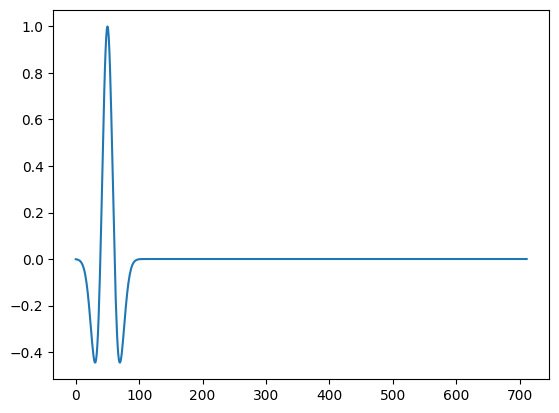

In [91]:
plt.plot(s)

<Figure size 640x480 with 0 Axes>

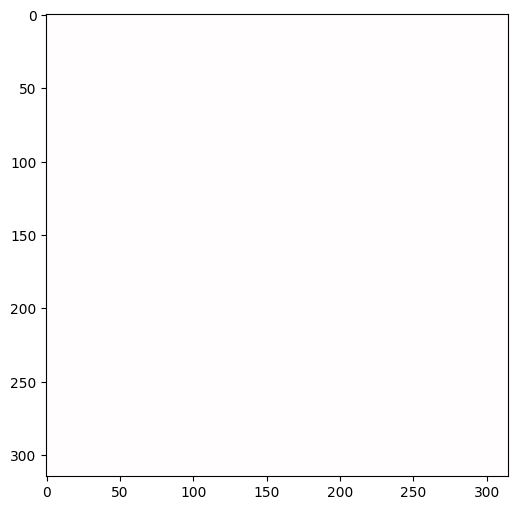

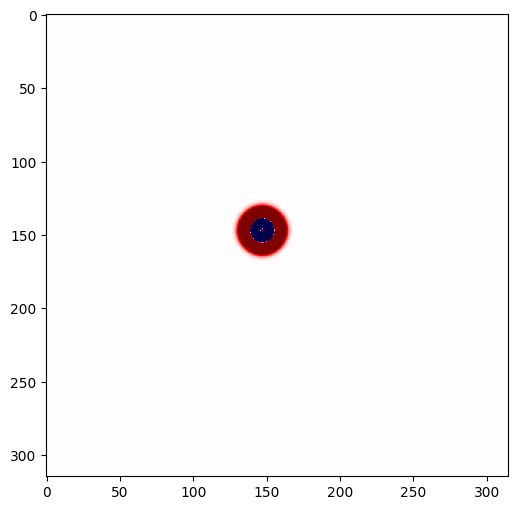

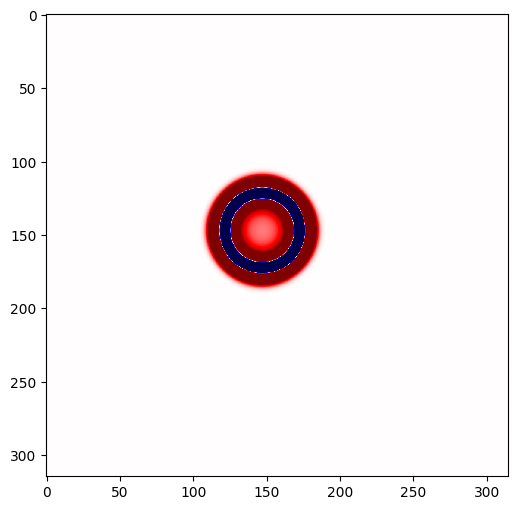

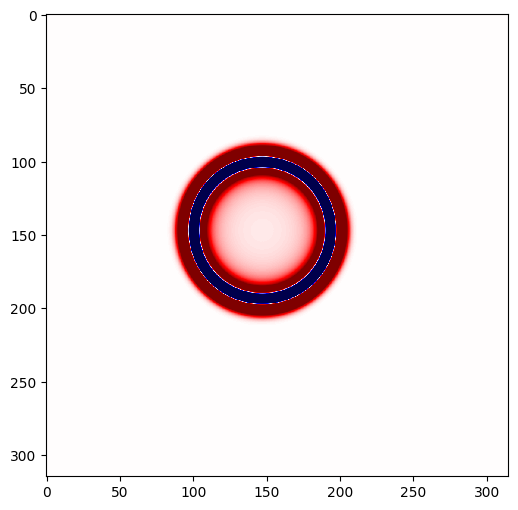

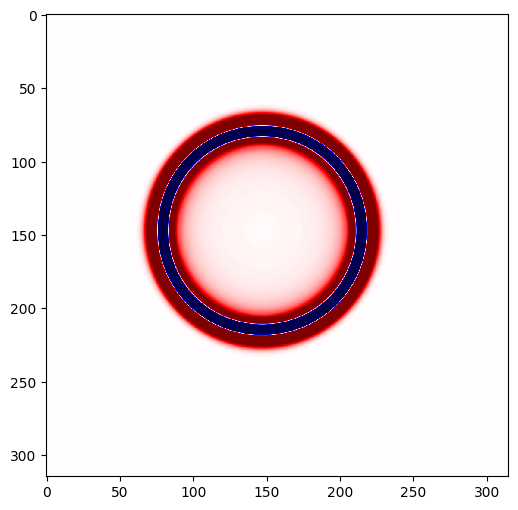

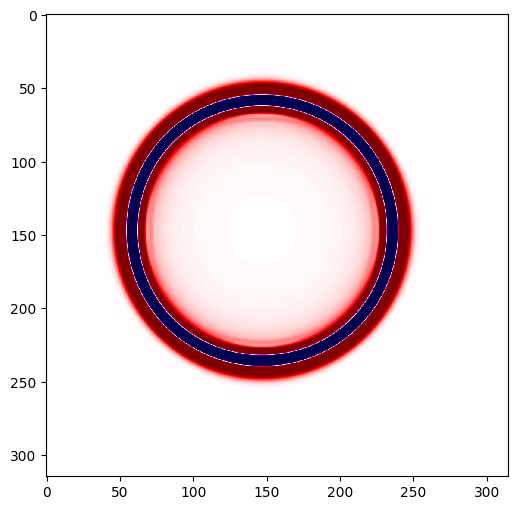

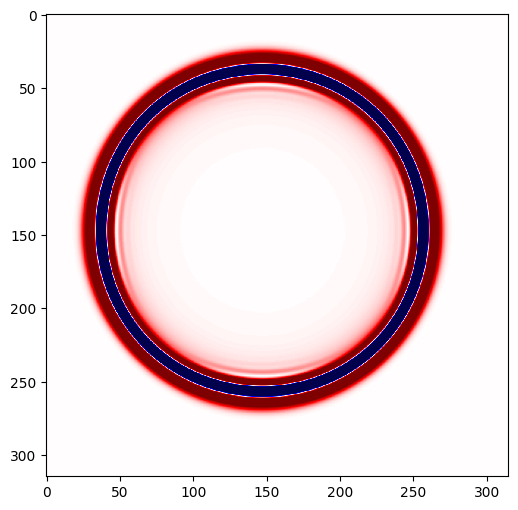

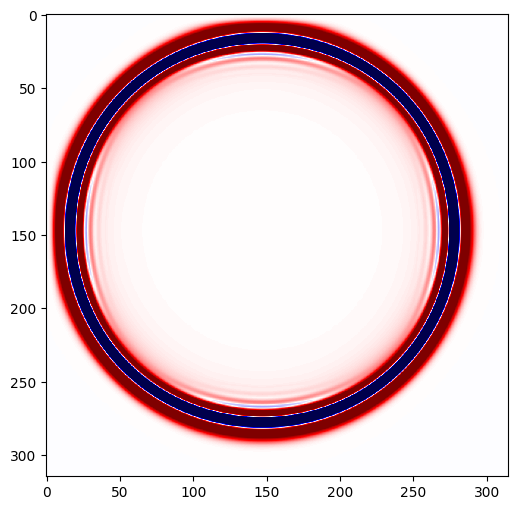

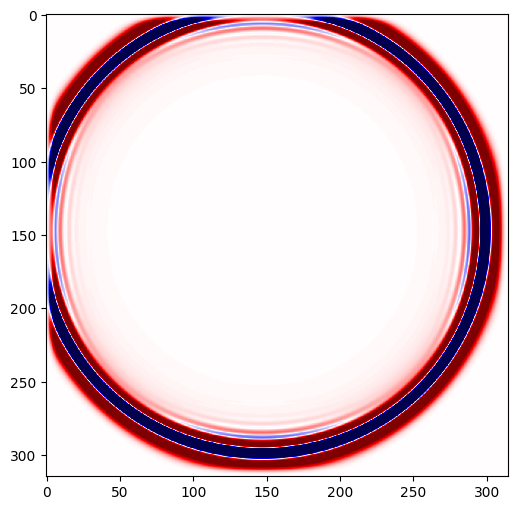

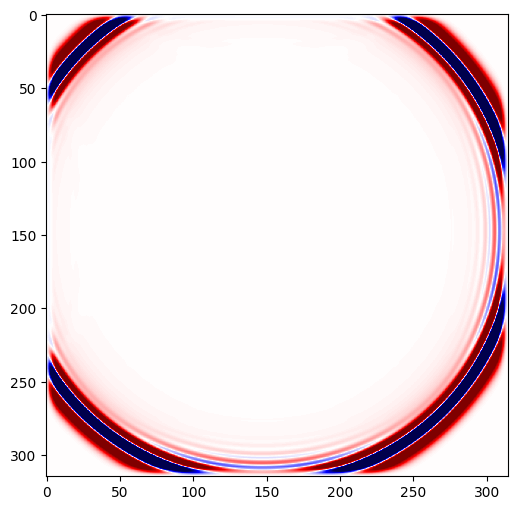

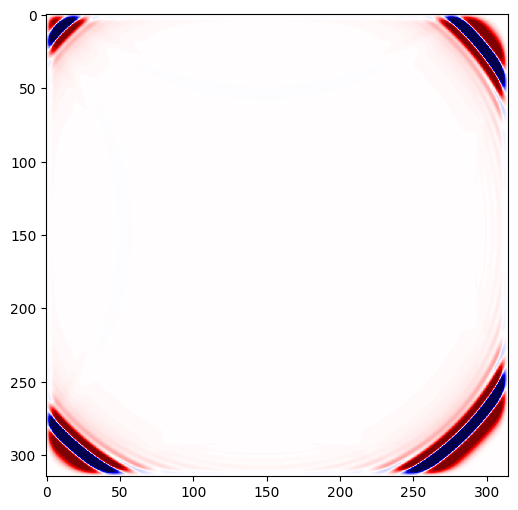

In [92]:
plt.figure()
s = 5*np.mean(np.abs(wavefields))
for it in range(0, NSTEPS, NSTEPS//10):
    plt.figure(figsize=(10,6))
    plt.imshow(-wavefields[it,:,:].T, vmin=-s, vmax=s,cmap='seismic')

In [63]:
def seismicCPML2D_with_source(NX,
                              NY,
                              NSTEPS,
                              DELTAX,
                              DELTAY,
                              DELTAT,
                              NPOINTS_PML,
                              velocity,
                              density,
                              initial_pressures,
                              source_position,
                              source_amplitude,
                              source_array,
                              dtype=np.float32,
                              output_wavefields=True,
                              gather_is=None):
    """
    Run seismicCPML2D with precomputed external time-varying source array.
    """

    # INPUT PARAMETERS
    velocity = velocity.astype(dtype)
    density = density.astype(dtype)

    if type(gather_is) != type(None):
        output_gather = True
    else:
        output_gather = False

    K_MAX_PML = 1.
    ALPHA_MAX_PML = 2.*np.pi*(20./2.)  # Assuming f0 is 20 for ALPHA_MAX_PML
    NPOWER = 2.
    Rcoef = 0.001

    STABILITY_THRESHOLD = 1e25

    # STABILITY CHECKS
    courant_number = np.max(velocity) * DELTAT * np.sqrt(1/(DELTAX**2) + 1/(DELTAY**2))
    if courant_number > 1.:
        raise Exception("ERROR: time step is too large, simulation will be unstable %.2f"%(courant_number))
    if NPOWER < 1:
        raise Exception("ERROR: NPOWER must be greater than 1")

    # GET DAMPENING PROFILES
    [[a_x, a_x_half, b_x, b_x_half, K_x, K_x_half],
     [a_y, a_y_half, b_y, b_y_half, K_y, K_y_half]] = get_dampening_profiles(velocity, NPOINTS_PML, Rcoef, K_MAX_PML, ALPHA_MAX_PML, NPOWER, DELTAT, DELTAS=(DELTAX, DELTAY), dtype=dtype, qc=False)

    # INITIALISE ARRAYS
    kappa = density*(velocity**2)

    pressure_present = initial_pressures[1].astype(dtype)
    pressure_past = initial_pressures[0].astype(dtype)

    memory_dpressure_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressure_dy = np.zeros((NX, NY), dtype=dtype)

    memory_dpressurexx_dx = np.zeros((NX, NY), dtype=dtype)
    memory_dpressureyy_dy = np.zeros((NX, NY), dtype=dtype)

    if output_wavefields:
        wavefields = np.zeros((NSTEPS, NX, NY), dtype=dtype)
    if output_gather:
        gather = np.zeros((gather_is.shape[0], NSTEPS), dtype=dtype)

    # precompute density_half arrays
    density_half_x = np.pad(0.5 * (density[1:NX,:]+density[:NX-1,:]), [[0,1],[0,0]], mode="edge")
    density_half_y = np.pad(0.5 * (density[:,1:NY]+density[:,:NY-1]), [[0,0],[0,1]], mode="edge")

    # Get source index in the grid
    source_ix, source_iy = source_position

    # RUN SIMULATION
    start = time.time()
    for it in range(NSTEPS):

        # compute the first spatial derivatives divided by density
        value_dpressure_dx = np.pad((pressure_present[1:NX,:]-pressure_present[:NX-1,:]) / DELTAX, [[0,1],[0,0]], mode="constant", constant_values=0.)
        value_dpressure_dy = np.pad((pressure_present[:,1:NY]-pressure_present[:,:NY-1]) / DELTAY, [[0,0],[0,1]], mode="constant", constant_values=0.)

        memory_dpressure_dx = b_x_half * memory_dpressure_dx + a_x_half * value_dpressure_dx
        memory_dpressure_dy = b_y_half * memory_dpressure_dy + a_y_half * value_dpressure_dy

        value_dpressure_dx = value_dpressure_dx / K_x_half + memory_dpressure_dx
        value_dpressure_dy = value_dpressure_dy / K_y_half + memory_dpressure_dy

        pressure_xx = value_dpressure_dx / density_half_x
        pressure_yy = value_dpressure_dy / density_half_y

        # compute the second spatial derivatives
        value_dpressurexx_dx = np.pad((pressure_xx[1:NX,:]-pressure_xx[:NX-1,:]) / DELTAX, [[1,0],[0,0]], mode="constant", constant_values=0.)
        value_dpressureyy_dy = np.pad((pressure_yy[:,1:NY]-pressure_yy[:,:NY-1]) / DELTAY, [[0,0],[1,0]], mode="constant", constant_values=0.)

        memory_dpressurexx_dx = b_x * memory_dpressurexx_dx + a_x * value_dpressurexx_dx
        memory_dpressureyy_dy = b_y * memory_dpressureyy_dy + a_y * value_dpressureyy_dy

        value_dpressurexx_dx = value_dpressurexx_dx / K_x + memory_dpressurexx_dx
        value_dpressureyy_dy = value_dpressureyy_dy / K_y + memory_dpressureyy_dy

        dpressurexx_dx = value_dpressurexx_dx
        dpressureyy_dy = value_dpressureyy_dy

        # apply the time evolution scheme
        pressure_future = (-pressure_past +
                           2 * pressure_present +
                           DELTAT*DELTAT*(dpressurexx_dx+dpressureyy_dy)*kappa)

        # Add time-varying source term using the precomputed source array
        pressure_future[source_ix, source_iy] += source_amplitude * source_array[it]

        # apply Dirichlet conditions at the edges
        pressure_future[0,:] = pressure_future[-1,:] = 0.
        pressure_future[:,0] = pressure_future[:,-1] = 0.

        if output_wavefields:
            wavefields[it,:,:] = np.copy(pressure_present)
        if output_gather:
            gather[:,it] = np.copy(pressure_present[gather_is[:,0], gather_is[:,1]])

        # check stability
        if np.max(np.abs(pressure_present)) > STABILITY_THRESHOLD:
            raise Exception('Code became unstable and blew up')

        # Move new values to old values
        pressure_past = pressure_present
        pressure_present = pressure_future

        if it % 10000 == 0 and it != 0:
            rate = (time.time()-start)/10.
            print("[%i/%i] %.2f s per step"%(it, NSTEPS, rate))
            start = time.time()

    output = [None, None]
    if output_wavefields:
        output[0] = wavefields
    if output_gather:
        output[1] = gather
    return output


In [67]:
 import numpy as np

def temporal_ricker_wavelet(NSTEPS, DELTAT, f0):
    
    t = np.linspace(0, NSTEPS * DELTAT, NSTEPS)

    # Define the Ricker wavelet
    ricker_wavelet = (1 - 2 * (np.pi * f0 * (t - 1/(f0)))**2) * np.exp(-(np.pi * f0 * (t - 1/(f0)))**2)

    return ricker_wavelet

# Parameters
f0 = 20  # Peak frequency of the Ricker wavelet
source_array = temporal_ricker_wavelet(NSTEPS=712, DELTAT=np.float32(0.0014064697), f0=f0)  # Shape will be (NSTEPS,)


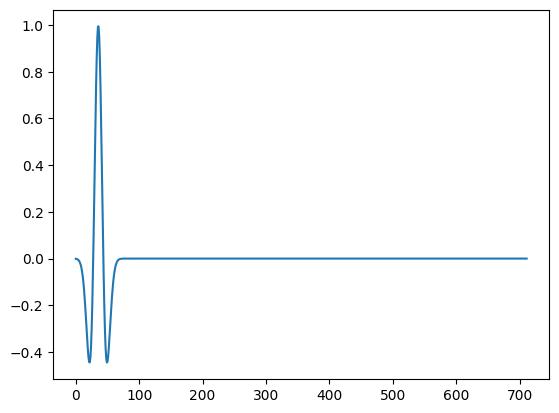

In [68]:
plt.plot(source_array)

In [70]:

# Run the simulation with an external source
wavefields, _ = seismicCPML2D_with_source(
    NX=NX,
    NY=NY,
    NSTEPS=NSTEPS,
    DELTAX=DELTAX,
    DELTAY=DELTAY,
    DELTAT=DELTAT,
    NPOINTS_PML=NPOINTS_PML,
    velocity=velocity,
    density=density,
    initial_pressures=(p0.copy(), p0.copy()),  # Initial conditions
    source_position=source_position,  # Source location
    source_amplitude=source_amplitude, 
    source_array=source_array,# Source strength
     
    dtype=dtype,
    output_wavefields=True,
    gather_is=None
)


<Figure size 640x480 with 0 Axes>

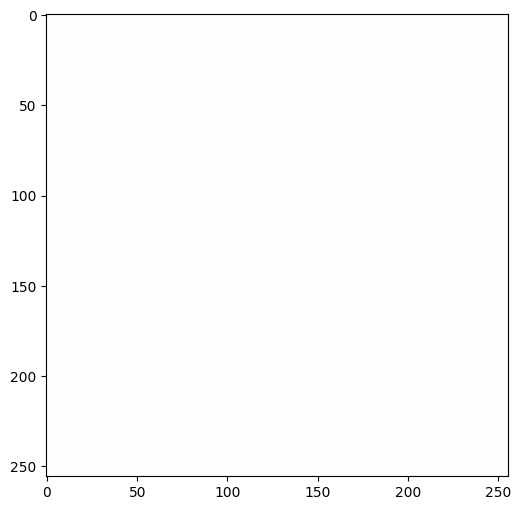

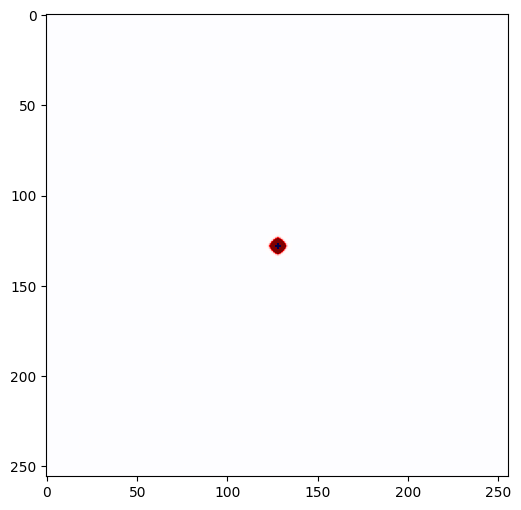

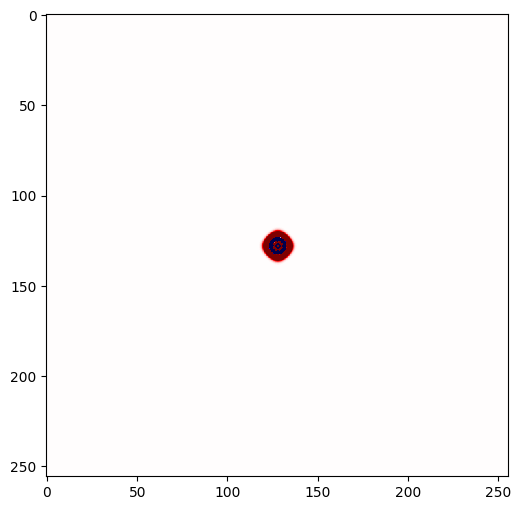

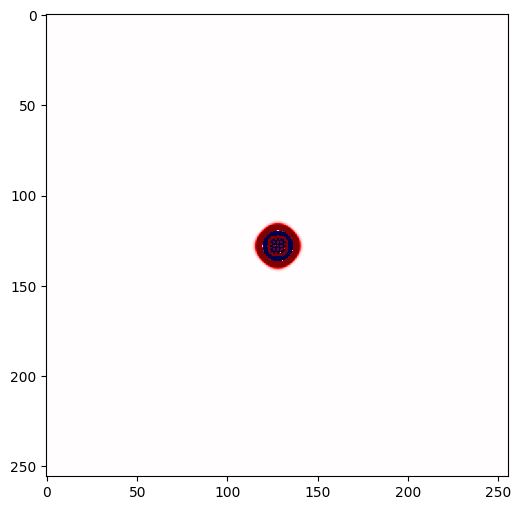

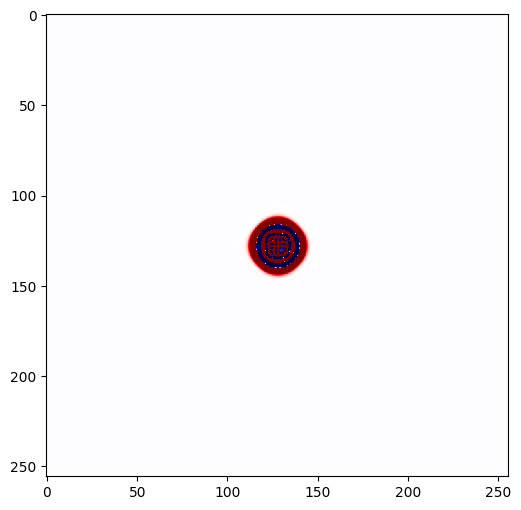

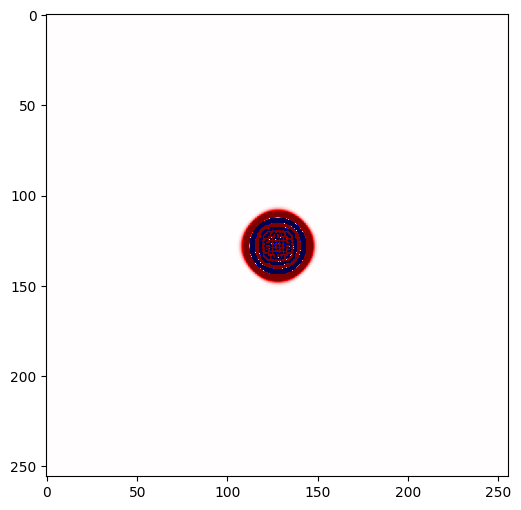

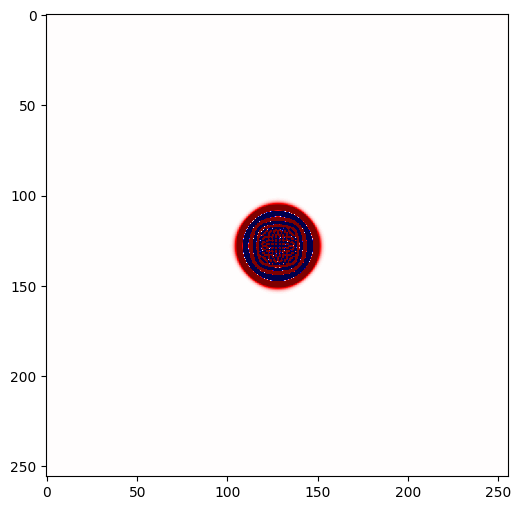

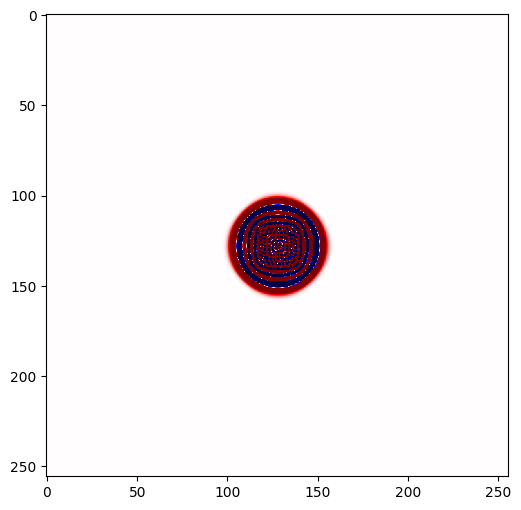

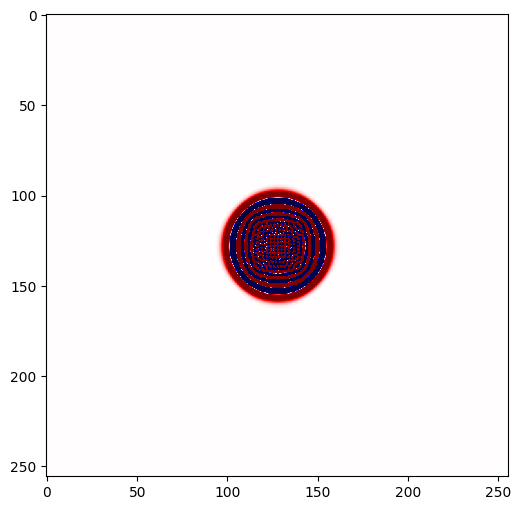

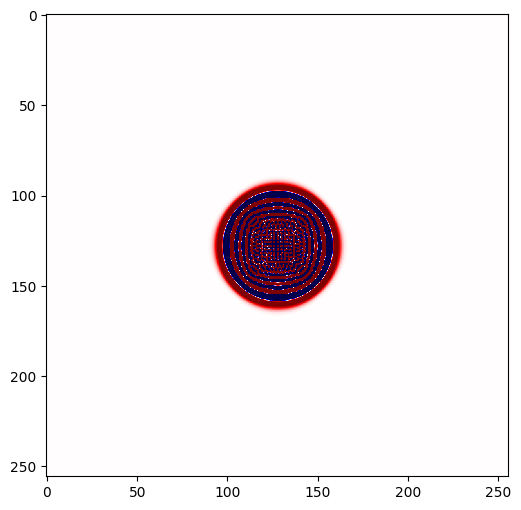

In [71]:
plt.figure()
s = 5*np.mean(np.abs(wavefields))
for it in range(0, NSTEPS, NSTEPS//10):
    plt.figure(figsize=(10,6))
    plt.imshow(-wavefields[it,:,:].T, vmin=-s, vmax=s,cmap='seismic')